In [24]:
#%matplotlib notebook
import uproot as ur
import matplotlib.pyplot as plt
import k3d
import numpy as np
import awkward as ak


## Get file and TTree, print branches, convert to array

In [49]:
piplus_events = ur.open("rec_pionplus.root:events")
pi0_events = ur.open("rec_pion0.root:events")

print(piplus_events.keys())

['mcparticles2', 'mcparticles2/mcparticles2.ID', 'mcparticles2/mcparticles2.g4Parent', 'mcparticles2/mcparticles2.reason', 'mcparticles2/mcparticles2.mask', 'mcparticles2/mcparticles2.steps', 'mcparticles2/mcparticles2.secondaries', 'mcparticles2/mcparticles2.pdgID', 'mcparticles2/mcparticles2.status', 'mcparticles2/mcparticles2.colorFlow[2]', 'mcparticles2/mcparticles2.genStatus', 'mcparticles2/mcparticles2.charge', 'mcparticles2/mcparticles2.spare[1]', 'mcparticles2/mcparticles2.spin[3]', 'mcparticles2/mcparticles2.vsx', 'mcparticles2/mcparticles2.vsy', 'mcparticles2/mcparticles2.vsz', 'mcparticles2/mcparticles2.vex', 'mcparticles2/mcparticles2.vey', 'mcparticles2/mcparticles2.vez', 'mcparticles2/mcparticles2.psx', 'mcparticles2/mcparticles2.psy', 'mcparticles2/mcparticles2.psz', 'mcparticles2/mcparticles2.pex', 'mcparticles2/mcparticles2.pey', 'mcparticles2/mcparticles2.pez', 'mcparticles2/mcparticles2.mass', 'mcparticles2/mcparticles2.time', 'mcparticles2/mcparticles2.properTime', 

In [50]:
def get_vector(events,varname='HcalEndcapHits',energy='energy'):
    E = events["%s.%s"%(varname,energy)].array(library='np')
    x = events["%s.position.x"%varname].array(library='np')
    y = events["%s.position.y"%varname].array(library='np')
    z = events["%s.position.z"%varname].array(library='np')
    #theta = events["%s.polar.theta"%varname].array(library='np')
    #phi = events["%s.polar.phi"%varname].array(library='np')

    return E,x, y, z, theta, phi

def get_truth(gen_events):
    pdgID = gen_events['mcparticles2.pdgID'].array(library='np')
    status = gen_events['mcparticles2.status'].array(library='np')
    genStatus = gen_events['mcparticles2.genStatus'].array(library='np')
    pex = gen_events['mcparticles2.psx'].array(library='np')
    pey = gen_events['mcparticles2.psy'].array(library='np')
    pez = gen_events['mcparticles2.psz'].array(library='np')
    mass = gen_events['mcparticles2.mass'].array(library='np')

    return pdgID,status, genStatus,pex,pey,pez,mass

In [51]:
E = {}
x = {}
y = {}
z  = {}
theta={}
phi = {}

## Get data

# get hits

In [52]:

for i in ['HcalHadronEndcap','EcalEndcapP']:#,'TrackerEndcap','VertexEndcap']:
    tag = 'piplus_' + i
    E[tag], x[tag], y[tag],z[tag],theta[tag],phi[tag] = get_vector(piplus_events,varname="%sHitsReco"%i)
    tag = 'pi0_' + i
    E[tag], x[tag], y[tag],z[tag],theta[tag],phi[tag] = get_vector(pi0_events,varname="%sHitsReco"%i)



## get MC

In [65]:
def get_GeneratedValues(events):
    mc = {} 
    mc['pdgID'], mc['status'], mc['genStatus'], mc['pex'],mc['pey'], mc['pez'], mc['mass']= get_truth(events)
    for i in range(len(mc['pdgID'][0])):
        if(mc['genStatus'][0][i] !=1): continue
        px = mc['pex'][0][i]
        py =  mc['pey'][0][i]
        pz = mc['pez'][0][i]
        pt =  np.sqrt(px*px + py*py)
        p = np.sqrt(px*px+py*py+pz*pz)
        theta = np.arccos(pz/p)*180/np.pi
        print('MC particle ID ', mc['pdgID'][ievt][i],  'genStatus ', mc['genStatus'][ievt][i],
               ' px = %2.2f, py=%2.2f, pz=%2.2f'%(mc['pex'][ievt][i],mc['pey'][ievt][i],mc['pez'][ievt][i]))
        print('p = %2.2f , theta =%2.2f'%(p, theta))
    return p, theta

truth = {}
truth['piplus_p'], truth['piplus_theta'] = get_GeneratedValues(piplus_events)
truth['pi0_p'], truth['pi0_theta'] = get_GeneratedValues(pi0_events)



MC particle ID  211 genStatus  1  px = 3.34, py=2.59, pz=9.07
p = 10.00 , theta =25.00
MC particle ID  111 genStatus  1  px = 0.64, py=4.18, pz=9.07
p = 10.01 , theta =25.00


## Get clusters

In [32]:
#for i in ['HcalBarrelClusters','HcalHadronEndcapClusters','EcalBarrelClusters','EcalEndcapClusters']:
#    E[i], x[i], y[i],z[i] = get_vector("%s"%i,energy='energy')

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

In [34]:
print(x.keys())

dict_keys(['piplus_HcalHadronEndcap', 'pi0_HcalHadronEndcap', 'piplus_EcalEndcapP', 'pi0_EcalEndcapP'])


## Plot 2D transverse view for hits in endcap

<ipython-input-96-2454bc5a84c3>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cell_x = x[key][ievt][mask]
<ipython-input-96-2454bc5a84c3>:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cell_y = y[key][ievt][mask]
<ipython-input-96-2454bc5a84c3>:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cell_E = E[key

piplus  Suma ECAL =0.21
pi0  Suma ECAL =2.76
piplus  Suma ECAL =1.11
pi0  Suma ECAL =2.71
piplus  Suma ECAL =0.28


No handles with labels found to put in legend.
No handles with labels found to put in legend.


pi0  Suma ECAL =2.79


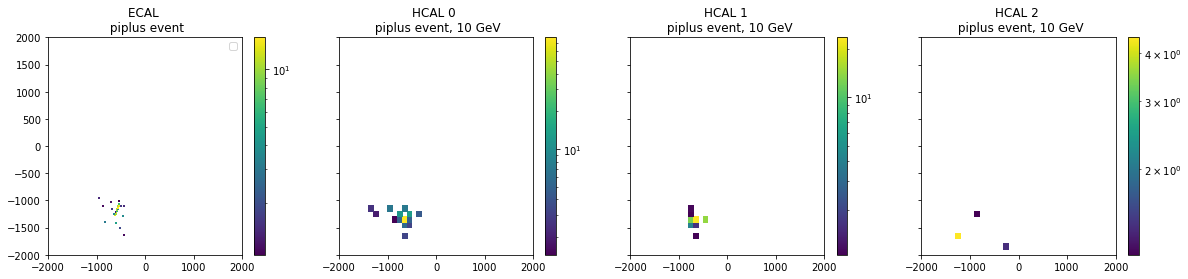

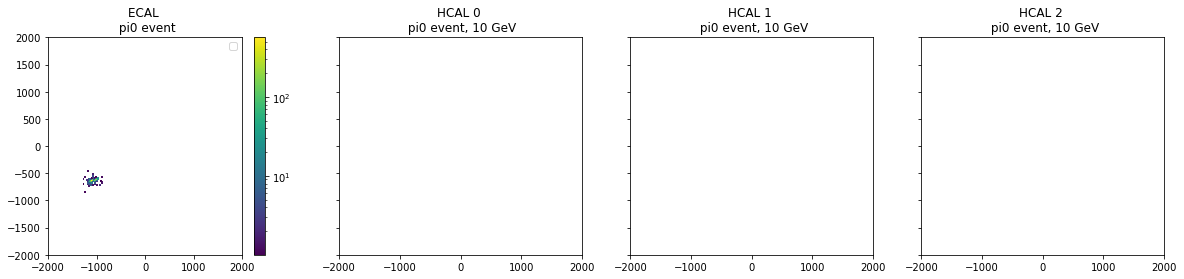

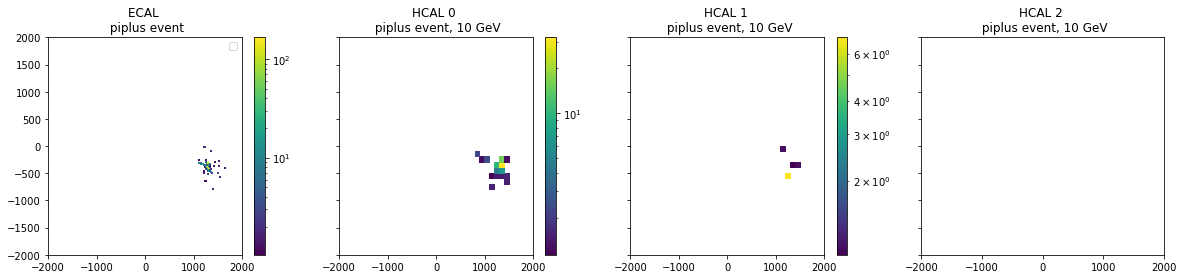

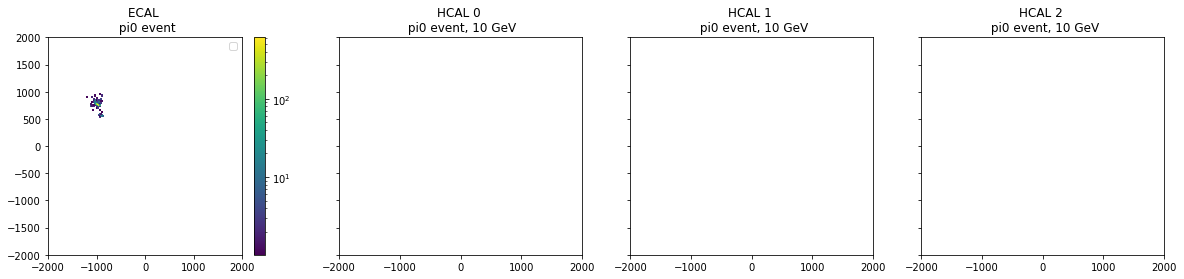

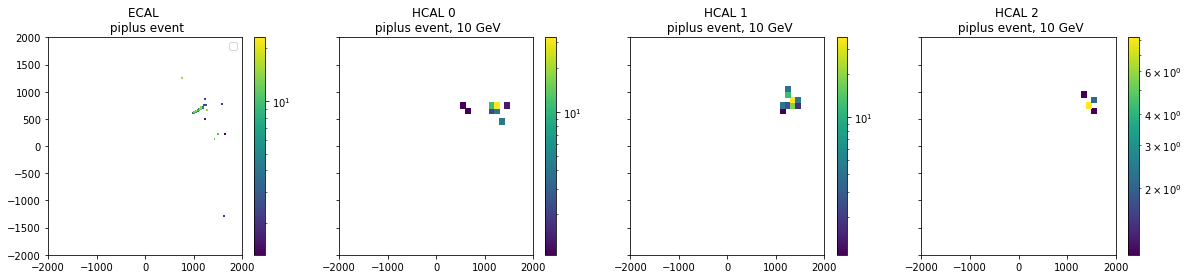

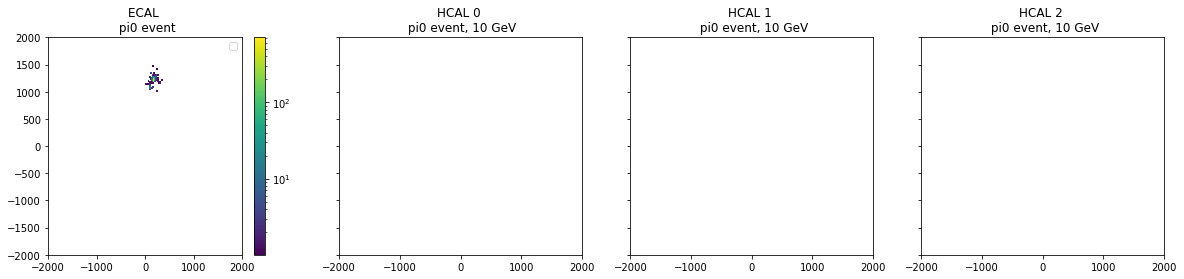

In [96]:
#loop over events

for ievt in range(3):
    for part_type in ['piplus','pi0']:
        #print(ievt)
        fig,ax  = plt.subplots(1,4,figsize=(20,4),sharex=True, sharey=True)

        key = '%s_EcalEndcapP'%(part_type)
        
        
#        mask = [(E[key][ievt]>0.005) & (E[key][ievt]/np.sum(E[key][ievt])>0.001)]
        mask = [(E[key][ievt]>0.001)]
   
        cell_x = x[key][ievt][mask]
        cell_y = y[key][ievt][mask]
        cell_E = E[key][ievt][mask]*1000.0 #(MeV)
        
        c = ax[0].hist2d(cell_x,cell_y, weights=cell_E,label=part_type + ' evt #%i'%(ievt), 
                     bins=[200,200],range=([[-2000, 2000], [-2000,2000]]),norm=LogNorm())
        fig.colorbar(c[3], ax=ax[0])            
        suma_ECAL = np.sum(E[key][ievt])
        print(part_type , ' Suma ECAL =%2.2f'%suma_ECAL)
        #### HCAL 
        key = '%s_HcalHadronEndcap'%(part_type)
        for iz, zbins in enumerate([(3000,3200),(3200,3400),(3400,3600)]):
            mask = [(z[key][ievt]>zbins[0]) & (z[key][ievt]<zbins[1]) & (E[key][ievt]>0.001)]
            if(np.sum(mask)<1): continue
            cell_x = x[key][ievt][mask]
            cell_y = y[key][ievt][mask]
            cell_E = E[key][ievt][mask] *1000.0 # MEV
             
            c = ax[iz+1].hist2d(cell_x,cell_y, weights=cell_E,label=part_type + ' evt #%i'%(ievt), 
                    bins=[40,40],range=([[-2000, 2000], [-2000,2000]]),norm=LogNorm())
            fig.colorbar(c[3], ax=ax[iz+1])            
        ax[0].set_title('ECAL \n %s event'%(part_type))
        for iz in range(3):
            ax[iz+1].set_title('HCAL %i \n %s event, %2.0f GeV'%(iz,part_type,truth[part_type+'_p']))

        ax[0].legend()
        #for a in ax:
        #    a.set_xticklabels([])
        #    a.set_yticklabels([])
        #plt.subplots_adjust(wspace=0, hspace=0.5)


In [ ]:
#sf_ECAL = 0.253
#sf_HCAL = 0.025
    #print('Energy = %2.3f'%(suma_ECAL/sf_ECAL+suma_HCAL/sf_HCAL))
    ##suma_HCAL = np.sum(E[key][ievt])
    #print(suma_HCAL/sf_HCAL)